# TD MLP simple

Cours de Julien VELCIN pour le Master MALIA

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import torch 
from torch.utils.data import DataLoader

# j'ai créé mes propres fonctions pour éviter les recopies inutiles
import custom_functions

## Chargement des données

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    random_state=100,
                                                    stratify=y)


num_data_train = train_X.shape[0]
num_data_test = test_X.shape[0]

## Transformer les données en Tenseurs 
X_train = torch.FloatTensor(train_X) # données sur R
X_test = torch.FloatTensor(test_X)
Y_train = torch.LongTensor(train_y) # LongTensor permet d'indiquer qu'il s'agit de données indexées (ici catégorielles)
Y_test = torch.LongTensor(test_y)
 
print("Dimension de Y",X_train.shape)
print("Dimension de X", Y_train.shape)

Dimension de Y torch.Size([75, 4])
Dimension de X torch.Size([75])


On transforme la variable cible pour obtenir un codage disjonctif complet, autrement appelé *one hot encoding* :

- 0 -> (1,0,0)
- 1 -> (0,1,0)
- 2 -> (0,0,1)

In [3]:
Y_train_cat = torch.nn.functional.one_hot(Y_train)
Y_test_cat = torch.nn.functional.one_hot(Y_test)

In [4]:
print(f"Premier exemple : {X_train[0,:]} de classe {Y_train_cat[0]}")

Premier exemple : tensor([7.2000, 3.0000, 5.8000, 1.6000]) de classe tensor([0, 0, 1])


# Mise en place de l'ingestion des données par le modèle

On met en place un objet personnel CustomDataset qui sera chargé de gérer les échantillons (*batch*)

In [5]:
dataset_train = custom_functions.CustomDataset(X_train, Y_train_cat)

In [6]:
batch_size = 10 # taille du (mini)batch = nombre d'exemples utilisés pour mettre à jour les poids
dataloader = custom_functions.get_dataloader(dataset_train, batch_size, shuffle=True)

## Définition du modèle

In [7]:
# Le modèle : un simple MLP à 1 couche cachée
D_in = 4  # dimension de l'input : 4 
D_hidden = 64 # dimension de la couche cachée : 64
D_out = 3 # dimension de l'output : 3
 
# Utilisation d'un constructeur séquentiel pour définir l'architecture du réseau
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out)
)
print(model) 
 
loss_fn = torch.nn.CrossEntropyLoss() # La fonction de coût cross entropy
learning_rate = 1e-2   # le pas d'apprentissage
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # l'optimiseur (ici simple SGD)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # l'optimiseur (ici Adam)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=3, bias=True)
)


Affichage de l'architecture avec une fonction "maison" :

In [8]:
# affichage des paramètres couche par couche, grâce à ma jolie fonction
custom_functions.summary(model)

Couche 0: [64, 4] (256 paramètres entrainables)
Couche 1: [64] (64 paramètres entrainables)
Couche 2: [3, 64] (192 paramètres entrainables)
Couche 3: [3] (3 paramètres entrainables)
  = 515 paramètres entrainables


## Lancer l'apprentissage

In [9]:
Nepochs = 200 # Nombre d'époques (Nombre de passes sur toutes les données) 
Nprint  = Nepochs/10  # fréquence de l'affichage

# mesures que l'on souhaite enregistrer pour monitorer l'apprentissage (log)
log_loss_batch = []
log_loss = []
log_acc_val = []

for epoch in range(Nepochs):
    total=0.
    for batch_idx, (data, target) in enumerate(dataloader): # 1 batch
        loss_batch=0.
        lenB = data.shape[0]        
        for i in range(lenB): # pour chaque exemple du batch
            optimizer.zero_grad()   ## réinitialiser les gradients (IMPORTANT !)
            prediction = model(data[i]).squeeze()   # passe "forward"
            loss = loss_fn(prediction, target[i].double()) # calcul de la fonction de coût courante
            loss.backward()  # backpropagation à travers le réseau       
            optimizer.step() # mise à jour des paramètres du réseau ( w = w -lr * w.grad) équivalent à une itération du SGD
            loss_batch+=loss # calcul de la loss sur tous les exemples du batch
        total += loss_batch # calcul de la loss sur tous les exemples d'entraînement
        # on enregistre les informations pour le monitoring
        log_loss_batch.append(loss_batch.item())
        pred_val = model(X_test)
        acc_val = custom_functions.get_accuracy_multiclass(pred_val,Y_test_cat)
        log_acc_val.append(acc_val)
    # affichage
    if epoch%Nprint==0:
        print(f"epoch {epoch} : loss {total:.4f} val {acc_val:.2%}")
    log_loss.append(total.item())

epoch 0 : loss 80.3626 val 66.67%
epoch 20 : loss 14.3202 val 98.67%
epoch 40 : loss 7.1503 val 93.33%
epoch 60 : loss 8.2362 val 96.00%
epoch 80 : loss 7.3514 val 97.33%
epoch 100 : loss 9.0221 val 96.00%
epoch 120 : loss 7.8742 val 98.67%
epoch 140 : loss 8.0786 val 98.67%
epoch 160 : loss 6.5924 val 90.67%
epoch 180 : loss 7.1385 val 93.33%


## Résultats

In [10]:
predictions_test = model(X_test)
acc_val = custom_functions.get_accuracy_multiclass(predictions_test,Y_test_cat)
print(f"accuracy : {acc_val:.2%}")

accuracy : 96.00%


In [11]:
Y_test_cat.shape

torch.Size([75, 3])

Regardons un peu l'évolution de l'erreur (par batch et pour toutes le données) afin de voir si tout s'est bien passé.

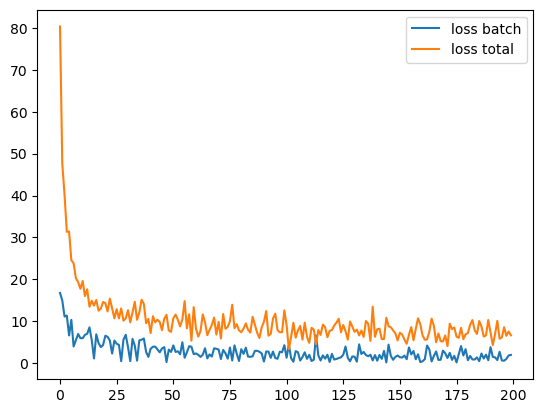

In [12]:
x = [i for i in range(0, 200)]

plt.plot(x, [log_loss_batch[i] for i in x], label="loss batch")
plt.plot(x, [log_loss[i] for i in x], label="loss total")
    
plt.legend()
plt.show()


On peut aussi regarder l'accuracy :

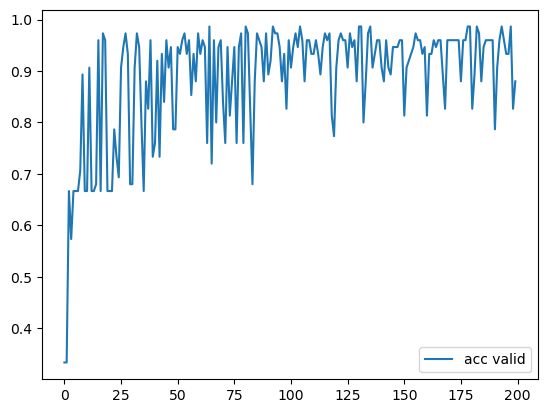

In [16]:
plt.plot(x, [log_acc_val[i] for i in x], label="acc valid")    
plt.legend()
plt.show()